# Thermovision segmentation (altitude & rotation)

## HIT-UAV Dataset

*HIT-UAV provides essential flight data for each image, including flight altitude, camera perspective, date, and daylight intensity. <br>
For each image, the authors have manually annotated object instances with bounding boxes of two types (oriented and standard) <br>to tackle the challenge of significant overlap of object instances in aerial images.*

In [1]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from pathlib import Path
from sklearn.utils import class_weight

from src.data import save_alt_rot_images_annotations
from src.utils.process_image import add_altitude_rotation_channel, mask_oriented_annotations
from src.utils.read_file import XMLReader, read_file_to_list
from src.visualizations import plot_rotated_images, mask_rotated_images
from src.models.unet import UNet

ANNOTATIONS_PATH = "data/HIT-UAV-Infrared-Thermal-Dataset/rotate_xml/Annotations"
DATA_SPLIT_PATH = "data/HIT-UAV-Infrared-Thermal-Dataset/rotate_xml/ImageSets/Main"
IMAGES_PATH = "data/HIT-UAV-Infrared-Thermal-Dataset/rotate_xml/JPEGImages"

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cpu')

#### Load annotations

In [2]:
xml_reader = XMLReader(ANNOTATIONS_PATH)
annotations = xml_reader.getAnnotation()

# examplary annotation
# annotations['0_100_30_0_03280']

In [3]:
image_names = dict()
for key in ["train", "val", "test"]:
    image_names[key] = read_file_to_list(f"{DATA_SPLIT_PATH}/{key}.txt")

#### Visualize n random images from the training set (images as well as their masks)

In [4]:
n = 10
random_images = np.random.choice(np.arange(len(image_names['train'])), n, replace=False)
random_images = [image_names['train'][i] for i in random_images]
# random_images

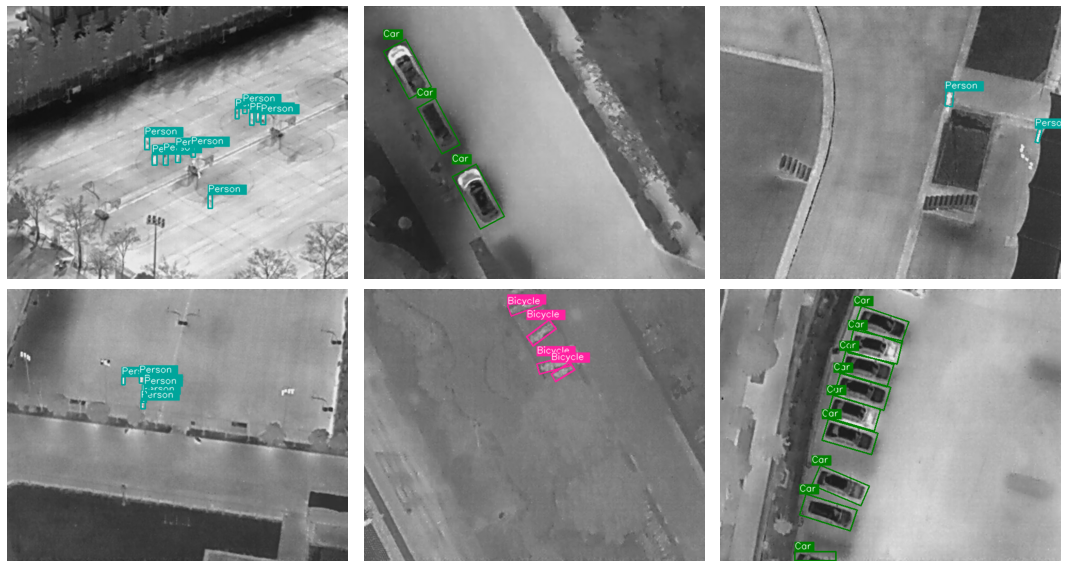

In [20]:
n = 6
rows = 2
cols = 3
figsize = (15, 8)
plot_rotated_images(IMAGES_PATH, 
                    random_images[:n], 
                    annotations, 
                    rows=rows, 
                    cols=cols, 
                    figsize=figsize)

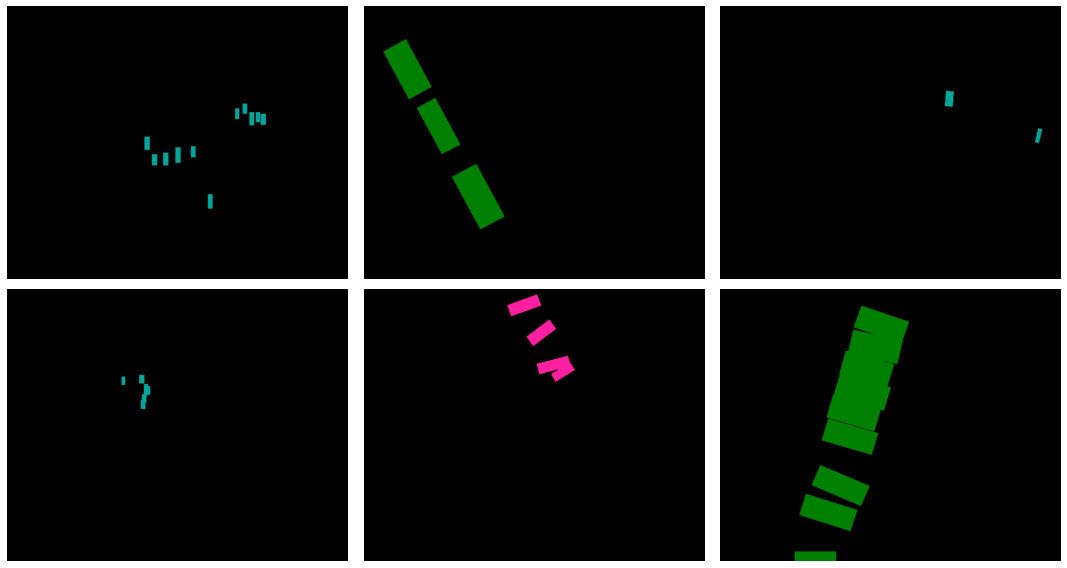

In [21]:
mask_rotated_images(IMAGES_PATH, 
                    random_images[:n], 
                    annotations, 
                    colored_masks=True,
                    rows=rows, 
                    cols=cols, 
                    figsize=figsize)

### Add the altitude information as an additional input channel

Following the idea from the paper: [Elevating point-based object detection in UAVs: A deep learning method with altitude fusion](https://ww2.mini.pw.edu.pl/pprai2024/papers/105.pdf) <br>(presented at the PP RAI 2024 conference), we added the information about the altitude as a separate channel (i.e. using *Method A*):

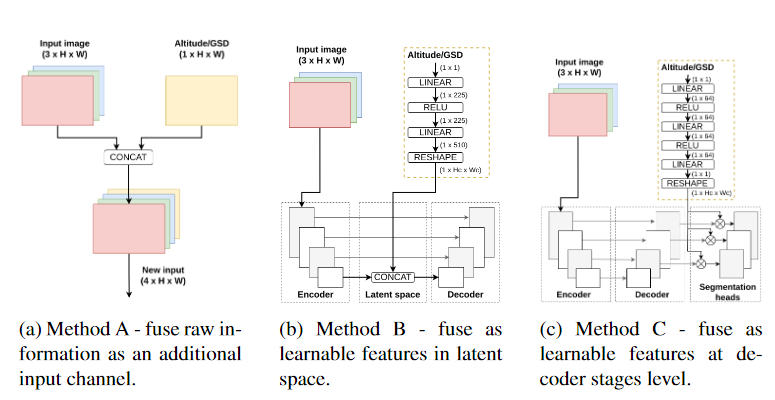

In [71]:
def preprocess_images(image_names: list,
                      annotations: dict,
                      num_classes: int = 6,
                      ) -> tuple[torch.Tensor, torch.Tensor]:
    
    all_images, all_masks = [], []
    for i_name in image_names:
        img = cv2.imread(f"{IMAGES_PATH}/{i_name}.jpg")
        img_alt_rot = add_altitude_rotation_channel(img, i_name)
        masked_image = mask_oriented_annotations(img, annotations[i_name])[:, :, 0, np.newaxis] # masks are from range 1-5, the background is 0
        all_images.append(img_alt_rot)
        all_masks.append(masked_image)

    all_images = np.array(all_images).astype(np.float32)
    all_masks = np.array(all_masks)
    all_masks = torch.tensor(all_masks).squeeze(-1).long() 
    # print(np.unique(all_masks))
    all_masks_cat = torch.nn.functional.one_hot(all_masks, num_classes=num_classes).numpy()
    all_masks_flat = all_masks.flatten().cpu().numpy()
    class_weights = torch.tensor(class_weight.compute_class_weight('balanced', classes=np.unique(all_masks_flat), y=all_masks_flat))
    # print(class_weights)

    return all_images, all_masks_cat, class_weights

In [72]:
# TODO: select all images for the training
n = 2
X_train, y_train, class_weights = preprocess_images(image_names['train'][:n], annotations)
X_test, y_test, _ = preprocess_images(image_names['test'][:n], annotations)

X_test.shape, y_test.shape

((2, 512, 640, 3), (2, 512, 640, 6))

In [73]:
channels_means = np.mean(X_train, axis=(0, 1, 2))
channels_stds = np.std(X_train, axis=(0, 1, 2))
channels_means, channels_stds

(array([112.56177, 120.7877 ,  69.248  ], dtype=float32),
 array([46.642914, 10.014346, 19.995237], dtype=float32))

In [74]:
class UAVDataset(Dataset):
    def __init__(self, images, labels, mean, std):
        self.images = images
        self.labels = labels
        self.transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean=mean, std=std)
                        ])
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            label = torch.tensor(label).permute(2, 0, 1).float()
        return image, label

In [75]:
def train(
    model: nn.Module,
    trainloader: DataLoader,
    valloader: DataLoader,
    num_epochs: int,
    device: str,
    lr: float = 1e-4,
    weight: torch.Tensor = None,
    save_path: str = None,
) -> tuple[nn.Module, list[float], list[float]]:
    
    criterion = nn.CrossEntropyLoss(weight=weight)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        step_losses = []
        with tqdm(trainloader, unit="batch") as tepoch:
            for input, target in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                optimizer.zero_grad()
                input, target = input.to(device), target.to(device)
                y_pred = model(input)
                loss = criterion(y_pred, target)
                loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss=loss.item())
                step_losses.append(loss.cpu().detach().numpy())
        train_losses.append(np.mean(step_losses))
        model.eval()
        running_vloss = 0.0
        with torch.no_grad():
            for i, vdata in enumerate(valloader):
                vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
                voutputs = model(vinputs)
                vloss = torch.sqrt(criterion(voutputs, vlabels))
                running_vloss += vloss

        avg_vloss = running_vloss / (i + 1)
        val_losses.append(avg_vloss.cpu().item())

        if save_path is not None and epoch % 10 == 0:
            torch.save(model.state_dict(), f"{save_path}_{epoch}.pth")

    return model, train_losses, val_losses

In [76]:
# model params: 34,5M
# from torchsummary import summary
# summary(model, (3, 512, 640))

In [77]:
train_dataset = UAVDataset(X_train, y_train, channels_means, channels_stds)
test_dataset = UAVDataset(X_test, y_test, channels_means, channels_stds)

# TODO: change batch_size
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [79]:
# UNet with altitude and rotation added - Method A
number_of_classes = 6 # 5 classes +1 because of the background class
model = UNet(out_ch=number_of_classes).to(DEVICE)

model, train_losses, val_losses = train(model, train_loader, test_loader, 
                                        num_epochs=2, 
                                        device=DEVICE,
                                        # weight=class_weights, # TODO: enable for the whole dataset training
                                        )

Epoch 1: 100%|██████████| 1/1 [00:33<00:00, 33.74s/batch, loss=1.79]


In [81]:
train_losses, val_losses

([1.8395329, 1.7860992], [1.3363566398620605, 1.336078405380249])

In [10]:
# # UNet with altitude and rotation added - Method B
# model = UNet(img_size=size, alt_rot_embedding=True)
# output = model(sample_tensor)
# print("Output shape:", output.shape)